In [3]:
from collections import defaultdict
from pymongo import MongoClient
import matplotlib

%matplotlib inline


client = MongoClient()
db = client["senators"]
coll = db["raw_xml"]

In [4]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.feature_extraction import DictVectorizer
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
import numpy as np
import random

def graph_senators(names, senators, model="agglomerative"):
    dict_vectorizer = DictVectorizer()
    features = dict_vectorizer.fit_transform(senators)

    if model == "agglomerative":
        labels = AgglomerativeClustering().fit_predict(features.toarray())
    elif model == "kmeans":
        labels = KMeans().fit_predict(features.toarray())

    matplotlib.rcParams['figure.figsize'] = (15.0,12.0)

    mds = MDS()
    coords = mds.fit_transform(features.toarray())
    plot = plt.scatter(coords[:,0], coords[:,1], c=labels, s=100)
    plt.axis("off")

    for i, (name, xy) in enumerate(zip(names, coords)):
        color = "blue" if labels[i] else "red"
        plt.annotate(name, xy = xy, xytext = (1, 1),
            textcoords = 'offset points', ha = 'right', va = 'bottom',
            bbox = dict(boxstyle = 'round,pad=0.3', fc=color,alpha = .4)
        )

In [50]:
obama_votes = defaultdict(dict)

for cong in range(111,115):
    for roll_call in coll.find({"congress": cong},{"raw":0}):
        for member in roll_call["votes"]:
            obama_votes[member["name"]][(cong, roll_call["session"],roll_call["vote_num"])] = member["vote_score"]

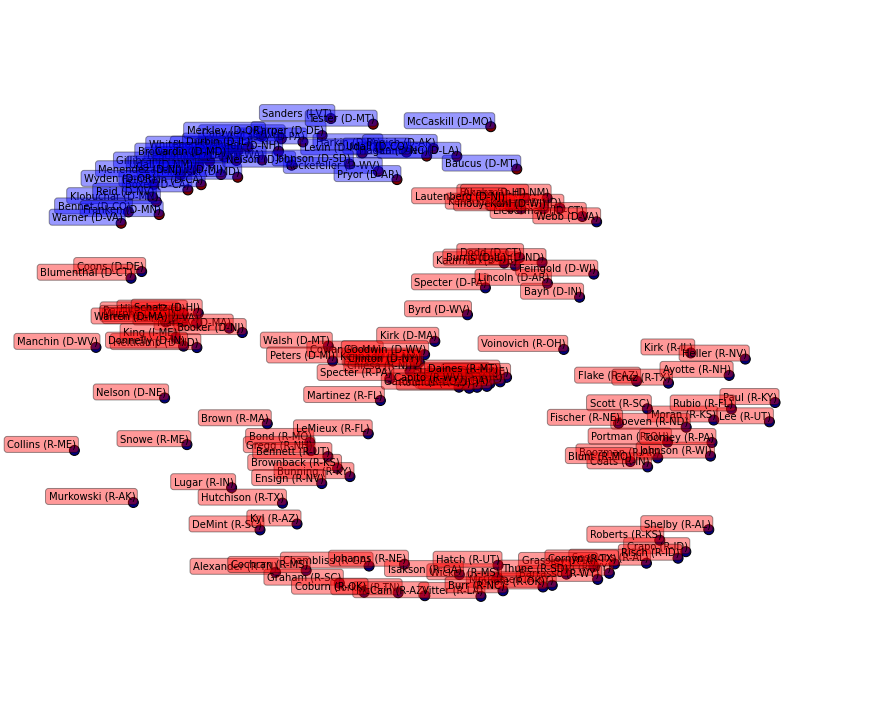

In [51]:
#Obama
senator_names = obama_votes.keys()
senators = [obama_votes[name] for name in senator_names]

graph_senators(senator_names, senators)

In [21]:
bush_votes = defaultdict(dict)

for cong in range(107,111):
    for roll_call in coll.find({"congress": cong},{"raw":0}):
        for member in roll_call["votes"]:
            bush_votes[member["name"]][(cong,roll_call["session"],roll_call["vote_num"])] = member["vote_score"]

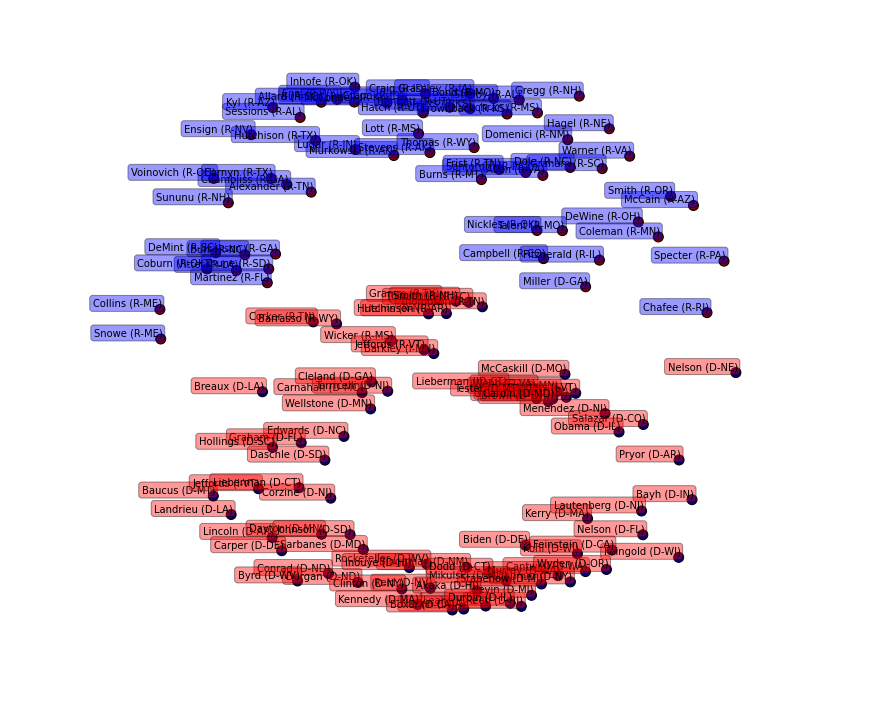

In [22]:
#Bush
senator_names = bush_votes.keys()
senators = [bush_votes[name] for name in senator_names]

graph_senators(senator_names, senators)

In [43]:
from sklearn.feature_selection import SelectKBest
from lxml import etree

def partisan_bills(votes):
    senator_names = [ name for name in votes.keys() if ("(R-" in name ) or ("(D-" in name) ]
    senators = [ votes[name] for name in senator_names ]
    truth = map(lambda name: int("(R-" in name), senator_names)
    
    bill_vectorizer = DictVectorizer()
    features = bill_vectorizer.fit_transform(senators)
    
    kbest = SelectKBest(k=25).fit(features, truth)
    top25 = np.argsort(kbest.scores_)[::-1][:25]
    bills = bill_vectorizer.get_feature_names()

    for cong, sess, vote_num in map(lambda i: bills[i], top25):
        raw_xml = coll.find({"congress": cong, "session": sess, "vote_num": vote_num},{"raw": 1})[0]['raw']
        root = etree.XML(raw_xml.encode('utf-8'))
        print root.xpath("//vote_question_text")[0].text
        print root.xpath("//vote_document_text")[0].text
        print
    

In [52]:
partisan_bills(obama_votes)

Guilty or Not Guilty H.Res. 1031
A resolution impeaching G. Thomas Porteous, Jr., judge of the United States District Court for the Eastern District of Louisiana, for high crimes and misdemeanors.

Guilty or Not Guilty H.Res. 1031
A resolution impeaching G. Thomas Porteous, Jr., judge of the United States District Court for the Eastern District of Louisiana, for high crimes and misdemeanors.

Guilty or Not Guilty H.Res. 1031
A resolution impeaching G. Thomas Porteous, Jr., judge of the United States District Court for the Eastern District of Louisiana, for high crimes and misdemeanors.

Guilty or Not Guilty H.Res. 1031
A resolution impeaching G. Thomas Porteous, Jr., judge of the United States District Court for the Eastern District of Louisiana, for high crimes and misdemeanors.

On the Amendment S.Amdt. 523 to S.Con.Res. 11 (No short title on file)
To prevent United States companies from getting tax benefits for moving jobs overseas, to end offshore tax loopholes including inversions

/usr/local/lib/python2.7/dist-packages/sklearn/feature_selection/univariate_selection.py:111: UserWarning: Features [[0 0 0 0]] are constant.
  UserWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/feature_selection/univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [45]:
partisan_bills(bush_votes)

On the Amendment S.Amdt. 211 to S.Con.Res. 18 (No short title on file)
To restore funding for tribal programs and provide necessary additional funding based on recommendations from Indian country

On the Amendment S.Amdt. 239 to S.Con.Res. 18 (No short title on file)
Relative to funding to the Office of Community Oriented Policing Services.

On the Amendment S.Amdt. 144 to S.Con.Res. 18 (No short title on file)
To ensure that 75-year solvency has been restored to Social Security before Congress considers new deficit-financed legislation that would increase mandatory spending or cut taxes.

On the Motion (Motion to Waive CBA Re: Byrd Amdt. No. 2414)
To provide for the suspension of the debate limitation on reconciliation legislation that causes a deficit or increases the deficit.

On the Motion (Motion To Waive CBA Re: Lautenberg Amdt. No. 2381)
To require certification prior to beneficiary enrollment in a prescription drug plan or an MA-PD plan that has a gap in the coverage of prescri